# Application of trained ZS-AMBER to a new task

## Reload a trained ZS-AMBER

In [1]:
%cd /mnt/home/zzhang/workspace/src/AMBER-ZeroShot/examples
%run zero_shot_nas.real_deepsea.py

/mnt/home/zzhang/workspace/src/AMBER-ZeroShot/examples


Using TensorFlow backend.


In [2]:
import sys
arg_str = """foo 
--train-file data/zero_shot_deepsea/train.h5 
--val-file data/zero_shot_deepsea/val.h5 
--model-space long_and_dilation 
--ppo
--wd outputs/new_20200919/test_feats/zs_amber/
--config-file data/zero_shot_deepsea/test_feats.random_6.config_file.tsv
--dfeature-name-file data/zero_shot_deepsea/dfeatures_ordered_list.txt
"""

arg_list = arg_str.split()
sys.argv = arg_list

# fake arg parsing
parser = argparse.ArgumentParser(description="experimental zero-shot nas")
parser.add_argument("--train-file", type=str, required=True, help="Path to the hdf5 file of training data.")
parser.add_argument("--val-file", type=str, required=True, help="Path to the hdf5 file of validation data.")
parser.add_argument("--model-space", default="simple", choices=['simple', 'long', 'long_and_dilation'], help="Model space choice")
parser.add_argument("--ppo", default=False, action="store_true", help="Use PPO instead of REINFORCE")
parser.add_argument("--wd", type=str, default="./outputs/zero_shot/", help="working dir")
parser.add_argument("--resume", default=False, action="store_true", help="resume previous run")
parser.add_argument("--config-file", type=str, required=True, help="Path to the config file to use.")
parser.add_argument("--dfeature-name-file", type=str, required=True, help="Path to file with dataset feature names listed one per line.")
parser.add_argument("--lockstep-sampling", default=False, action="store_true", help="Ensure same training samples used for all models.")

arg = parser.parse_args()
print(arg)

Namespace(config_file='data/zero_shot_deepsea/test_feats.random_6.config_file.tsv', dfeature_name_file='data/zero_shot_deepsea/dfeatures_ordered_list.txt', lockstep_sampling=False, model_space='long_and_dilation', ppo=True, resume=False, train_file='data/zero_shot_deepsea/train.h5', val_file='data/zero_shot_deepsea/val.h5', wd='outputs/new_20200919/test_feats/zs_amber/')


In [3]:
configs, config_keys, controller, model_space = read_configs(arg, is_training=False)

{3: 0, 4: 1, 5: 2, 6: 0, 8: 2}


/mnt/home/zzhang/workspace/src/AMBER-ZeroShot/amber/architect/_general_controller.py:541: UserWarning: 
 [<tf.Variable 'controller/create_weights/g_emb:0' shape=(1, 128) dtype=float32_ref>, <tf.Variable 'controller/create_weights/emb/layer_9/w_start:0' shape=(3, 128) dtype=float32_ref>]
  optim_algo=self.optim_algo


In [4]:
# get random 4 testing features
test_feats = [
    'FEAT480',  # "YY1"   "H1-hESC"
    #'FEAT710',  # "PU.1"  "K562"
    'FEAT282',  # "DNase" "WI-38"
    #'FEAT515'   # "GTF2F1"        "HeLa-S3"
]
print(type(configs))
configs = {k:configs[k] for k in configs if configs[k]['feat_name'] in test_feats}

<class 'dict'>


In [5]:
controller.load_weights("outputs/new_20200919/long_and_dilation.ppo.0/controller_weights.h5")
for k in configs:
    print(configs[k]['feat_name'])
    a, p = controller.get_action(np.expand_dims(configs[k]['dfeatures'],0))
    print(a); print(p)
    print('-'*10)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/amber-zh/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


FEAT480
[3 0 2 6 1 2 6 0 2 0]
[array([[8.0534242e-12, 4.3316533e-09, 8.5733082e-10, 1.0000000e+00,
        8.2404439e-12, 5.5461019e-10, 6.4222593e-11]], dtype=float32), array([[1.0000000e+00, 1.1177606e-13]], dtype=float32), array([[1.3930006e-13, 2.8718092e-13, 1.0000000e+00]], dtype=float32), array([[7.0824450e-14, 7.6637474e-11, 9.5581338e-12, 9.5180344e-09,
        2.3586165e-13, 3.2427332e-11, 1.0000000e+00]], dtype=float32), array([[5.3825455e-10, 1.0000000e+00]], dtype=float32), array([[5.3258975e-14, 1.0959014e-12, 1.0000000e+00]], dtype=float32), array([[2.8883767e-17, 2.0327639e-15, 2.3332895e-14, 2.3591358e-15,
        6.0238449e-17, 5.9949014e-14, 1.0000000e+00]], dtype=float32), array([[1.0000000e+00, 1.4743487e-18, 2.2894671e-16, 1.0035300e-17]],
      dtype=float32), array([[7.282041e-14, 9.567595e-13, 1.000000e+00]], dtype=float32), array([[1.0000000e+00, 3.4371446e-17, 6.5259918e-16]], dtype=float32)]
----------
FEAT282
[3 1 0 6 1 2 6 0 2 0]
[array([[1.1649705e-13, 3.

In [6]:
n_rep = 10
# full data is 4.4m with pos+neg strands
full_training_patience = 40
zs_res = {}

global_manager_trial_cnt = {k:0 for k in configs}
global_manager_record = pd.DataFrame(columns=['manager', 'feat_name', 'amber', 'step', 'arc', 'reward'])

for k in configs:
    feat_name = configs[k]['feat_name']
    print('-'*10); print(feat_name); print('-'*10)
    res_list = []
    manager = configs[k]['manager']
    manager._earlystop_patience = full_training_patience
    manager.verbose=0
    for i in range(n_rep):
        arc, prob = controller.get_action(np.expand_dims(configs[k]['dfeatures'],0))
        reward, _ = manager.get_rewards(trial=global_manager_trial_cnt[k], model_arc=arc)
        global_manager_trial_cnt[k] += 1
        print(reward)
        res_list.append(reward)
        global_manager_record = global_manager_record.append({
            'manager': k, 
            'feat_name': feat_name, 
            'amber': 'zs', 
            'step': i,
            'arc': ','.join([str(a) for a in arc]),
            'reward': reward
        }, ignore_index=True)
    zs_res[k] = res_list

----------
FEAT480
----------


[1096018][12:18:57] Preprocessing..  0.257 sec
[1096018][12:18:57] Trial 0: Start training model..  543.330 sec
[1096018] Postprocessing..WARNING: Logging before flag parsing goes to stderr.
W0927 12:28:02.168078 46912496537280 font_manager.py:1282] findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  4.733 sec
[1096018] Cleaning up..  0.266 sec
[1096018][12:28:06] Preprocessing..

0.9315529989546129


  0.193 sec
[1096018][12:28:06] Trial 1: Start training model..  368.911 sec
[1096018] Postprocessing..  3.733 sec
[1096018] Cleaning up..  0.280 sec
[1096018][12:34:19] Preprocessing..  0.189 sec
[1096018][12:34:19] Trial 2: Start training model..

0.8750490025263524


  450.815 sec
[1096018] Postprocessing..  4.323 sec
[1096018] Cleaning up..  0.288 sec
[1096018][12:41:54] Preprocessing..

0.9129184271277987


  0.189 sec
[1096018][12:41:55] Trial 3: Start training model..  410.508 sec
[1096018] Postprocessing..  3.699 sec
[1096018] Cleaning up..  0.286 sec
[1096018][12:48:49] Preprocessing..  0.188 sec
[1096018][12:48:49] Trial 4: Start training model..

0.891388622702326


  410.955 sec
[1096018] Postprocessing..  4.284 sec
[1096018] Cleaning up..  0.339 sec
[1096018][12:55:45] Preprocessing..

0.8946840425995296


  0.190 sec
[1096018][12:55:45] Trial 5: Start training model..  289.431 sec
[1096018] Postprocessing..  3.578 sec
[1096018] Cleaning up..  0.315 sec
[1096018][13:00:38] Preprocessing..  0.188 sec
[1096018][13:00:39] Trial 6: Start training model..

0.8546857304643263


  329.195 sec
[1096018] Postprocessing..  3.783 sec
[1096018] Cleaning up..  0.437 sec
[1096018][13:06:12] Preprocessing..

0.8844942394807911


  0.189 sec
[1096018][13:06:12] Trial 7: Start training model..  351.772 sec
[1096018] Postprocessing..  3.746 sec
[1096018] Cleaning up..  0.460 sec
[1096018][13:12:08] Preprocessing..

0.8762454808781253


  0.202 sec
[1096018][13:12:08] Trial 8: Start training model..  305.547 sec
[1096018] Postprocessing..  3.729 sec
[1096018] Cleaning up..  0.367 sec
[1096018][13:17:18] Preprocessing..  0.188 sec
[1096018][13:17:18] Trial 9: Start training model..

0.8912947011934838


  389.608 sec
[1096018] Postprocessing..  3.683 sec
[1096018] Cleaning up..  0.432 sec
[1096018][13:23:52] Preprocessing..

0.9089859743880129
----------
FEAT282
----------


  0.240 sec
[1096018][13:23:52] Trial 0: Start training model..  444.024 sec
[1096018] Postprocessing..  3.594 sec
[1096018] Cleaning up..  0.526 sec
[1096018][13:31:20] Preprocessing..

0.853675378797201


  0.196 sec
[1096018][13:31:20] Trial 1: Start training model..  444.287 sec
[1096018] Postprocessing..  4.292 sec
[1096018] Cleaning up..  0.551 sec
[1096018][13:38:50] Preprocessing..

0.8496507354449174


  0.200 sec
[1096018][13:38:50] Trial 2: Start training model..  438.673 sec
[1096018] Postprocessing..  3.711 sec
[1096018] Cleaning up..  0.429 sec
[1096018][13:46:13] Preprocessing..

0.8567129344785438


  0.190 sec
[1096018][13:46:13] Trial 3: Start training model..  265.441 sec
[1096018] Postprocessing..  3.877 sec
[1096018] Cleaning up..  0.547 sec
[1096018][13:50:43] Preprocessing..

0.7363563277795552


  0.190 sec
[1096018][13:50:43] Trial 4: Start training model..  435.864 sec
[1096018] Postprocessing..  3.626 sec
[1096018] Cleaning up..  0.377 sec
[1096018][13:58:03] Preprocessing..

0.8735104471734796


  0.189 sec
[1096018][13:58:03] Trial 5: Start training model..  445.175 sec
[1096018] Postprocessing..  4.180 sec
[1096018] Cleaning up..  0.634 sec
[1096018][14:05:33] Preprocessing..

0.8589647987268149


  0.192 sec
[1096018][14:05:33] Trial 6: Start training model..  432.812 sec
[1096018] Postprocessing..  4.046 sec
[1096018] Cleaning up..  0.509 sec
[1096018][14:12:51] Preprocessing..

0.8737573729070788


  0.195 sec
[1096018][14:12:51] Trial 7: Start training model..  431.261 sec
[1096018] Postprocessing..  3.793 sec
[1096018] Cleaning up..  0.690 sec
[1096018][14:20:07] Preprocessing..

0.8718162167039927


  0.194 sec
[1096018][14:20:07] Trial 8: Start training model..  442.910 sec
[1096018] Postprocessing..  3.839 sec
[1096018] Cleaning up..  0.601 sec
[1096018][14:27:34] Preprocessing..

0.8728504745732123


  0.192 sec
[1096018][14:27:34] Trial 9: Start training model..  445.529 sec
[1096018] Postprocessing..  3.853 sec
[1096018] Cleaning up..

0.8755490200904027


  0.634 sec


<Figure size 900x900 with 0 Axes>

In [7]:
print(zs_res)

{0: [0.9315529989546129, 0.8750490025263524, 0.9129184271277987, 0.891388622702326, 0.8946840425995296, 0.8546857304643263, 0.8844942394807911, 0.8762454808781253, 0.8912947011934838, 0.9089859743880129], 2: [0.853675378797201, 0.8496507354449174, 0.8567129344785438, 0.7363563277795552, 0.8735104471734796, 0.8589647987268149, 0.8737573729070788, 0.8718162167039927, 0.8728504745732123, 0.8755490200904027]}


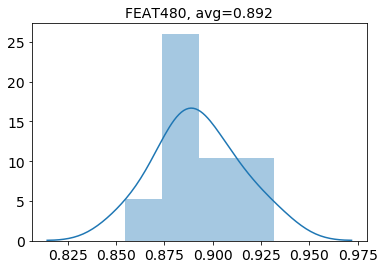

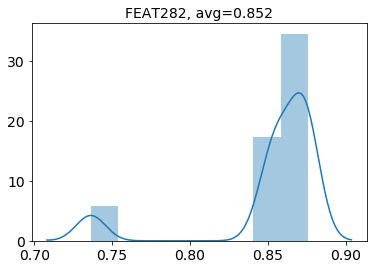

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

for k in configs:
    res_list = zs_res[k]
    ax =sns.distplot(res_list)
    ax.set_title("%s, avg=%.3f"%(configs[k]['feat_name'], np.mean(res_list)))
    plt.show()

# Reload single-run AMBER and re-train for full epochs

In [145]:
from datetime import datetime
import os

par_wd = "/mnt/home/zzhang/workspace/src/AMBER-ZeroShot/examples/outputs/new_20200919/test_feats/single_run/"
sr_hist = {}
for k in configs:
    feat_name = configs[k]['feat_name']
    wd = "%s/%s/" % (par_wd, feat_name)
    train_hist = pd.read_table(os.path.join(wd,"train_history.csv"), header=None, sep=",")
    train_hist.head()
    # each controller step has 5 child networks sampled..
    train_hist['step'] = train_hist[0]//5
    train_hist['auc'] = train_hist[2]
    dt = []
    for i in range(train_hist.shape[0]):
        child_model_fp = os.path.join(wd, "weights", "trial_%i"%train_hist.iloc[i][0])
        timestamp = os.path.getmtime(child_model_fp)
        timestamp = datetime.fromtimestamp(timestamp)
        if i==0:
            starttime = timestamp
        dt.append(timestamp - starttime)

    train_hist['ctime'] = dt
    train_hist = train_hist.loc[train_hist['step']<=60]
    sr_hist[k] = train_hist

In [146]:
delta_time = [sr_hist[k].ctime.tail(1) for k in configs]
print(delta_time)
#sns.distplot(delta_time)

[304   1 days 23:48:00.911253
Name: ctime, dtype: timedelta64[ns], 304   2 days 04:19:56.292139
Name: ctime, dtype: timedelta64[ns]]


In [147]:
sampling_interval = 5
do_retrain = False
n_rep = 10

sr_res = {}
for k in configs:
    np.random.seed(1223)
    train_hist = sr_hist[k]
    single_run_res = {}
    step_time = {}
    arc_seq_cols = np.arange(3, 13, dtype='int')
    steps_to_retrain = np.arange(0, train_hist['step'].max(), sampling_interval)
    #steps_to_retrain = np.concatenate([steps_to_retrain, [train_hist['step'].max()]])
    print(steps_to_retrain)
    for step in steps_to_retrain[1:]:
        #arcs = train_hist.loc[train_hist['step'] == step]
        step_idx = (train_hist['step']<=step) & (train_hist['step']>step-sampling_interval)
        arcs = train_hist.loc[ step_idx ]
        arcs = arcs[arc_seq_cols].to_numpy()
        #orig_rewards = train_hist.loc[train_hist['step'] == step]['auc'].to_numpy()
        orig_rewards = train_hist.loc[step_idx]['auc'].to_numpy()
        orig_runtime = train_hist.loc[step_idx]['ctime'].to_numpy()
        samp_idx = np.random.choice(arcs.shape[0], n_rep, replace=(n_rep>arcs.shape[0]))
        arcs = arcs[samp_idx]
        orig_rewards = orig_rewards[samp_idx]
        orig_runtime = orig_runtime[samp_idx]

        single_run_res[step] = []
        step_time[step] = []
        for i in range(n_rep):
            if do_retrain:
                reward, _ = manager.get_rewards(trial=global_manager_trial_cnt[k], model_arc=arcs.iloc[i])
                print(reward)
            else:
                reward = orig_rewards[i]
            global_manager_trial_cnt[k] += 1
            single_run_res[step].append(reward)
            step_time[step].append(orig_runtime[i])
            global_manager_record = global_manager_record.append({
                'manager': k, 
                'feat_name': feat_name, 
                'amber': 'sr', 
                'step': step,
                'arc': ','.join([str(a) for a in arcs[i]]),
                'reward': reward
            }, ignore_index=True)

    sr_df = pd.DataFrame([(k,v1, v2) for k in single_run_res for v1, v2 in zip(*[single_run_res[k], step_time[k]])], columns=['step', 'auc', 'time'])
    sr_res[k] = sr_df

[ 0  5 10 15 20 25 30 35 40 45 50 55]
[ 0  5 10 15 20 25 30 35 40 45 50 55]


## Merge with single-run AMBER

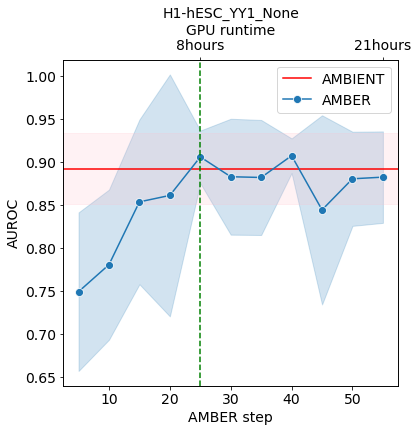

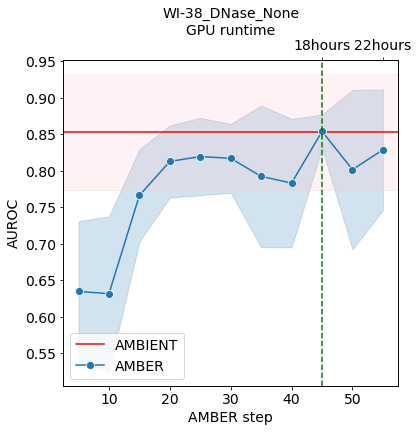

In [150]:
from zs_config import read_metadata

meta = read_metadata()

def convert_timedelta(duration):
    days, seconds = duration.days, duration.seconds
    hours = days * 24 + seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = (seconds % 60)
    return hours, minutes, seconds

for k in configs:
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax2 = ax.twiny()
    feat_name = configs[k]['feat_name']
    human_readable_name = meta.loc[feat_name]['new_name']
    sr_df = sr_res[k]
    zs_auc = zs_res[k]
    ax.axhspan(np.mean(zs_auc)-2*np.std(zs_auc), np.mean(zs_auc)+2*np.std(zs_auc), alpha=0.2, color='pink')
    ax.axhline(y=np.mean(zs_auc), color='red', label="AMBIENT")
    sns.lineplot(x='step', y='auc', marker='o', ci='sd', label="AMBER", data=sr_df, ax=ax)
    #ax.set_title("Manager%i:%s:%s"%(k,feat_name, human_readable_name))
    ax.set_title("%s"%(human_readable_name))
    ax.set_xlabel("AMBER step")
    ax.set_ylabel("AUROC")

    # add run-time as second x-axis
    ax2.set_xlim(ax.get_xlim())
    sr_auc_mean = sr_df.groupby("step").mean()
    new_tick_locations = [(sr_auc_mean-np.mean(zs_auc)>0).idxmax().tolist()[0], sr_df['step'].max()]
    #print(new_tick_locations)
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(sr_df.loc[new_tick_locations, "time"].apply(
        lambda x: "%shours"%convert_timedelta(x)[0]))
    ax2.set_xlabel("GPU runtime")
    ax2.axvline(x=new_tick_locations[0], linestyle='--', color='green')
    
    plt.savefig("./outputs/new_20200919/ZS_SR_comparison.%s.pdf"%human_readable_name)    
    plt.show()

In [151]:
global_manager_record.to_csv("outputs/new_20200919/ZS_SR_comparison.tsv", sep="\t")